# 4.0 Random Forest Regression Results Analysis

## Notebook Setup: Imports and Configuration


In [1]:
# ─────────────────────────────
# Standard Library Imports
# ─────────────────────────────
import os
import sys
import time
import copy
import re
import itertools as it
from pprint import pprint

# ─────────────────────────────
# Adjust sys.path for Local Modules
# ─────────────────────────────
sys.path.append(os.path.abspath(os.path.join('..', '..', 'src')))

# ─────────────────────────────
# Third-Party Imports
# ─────────────────────────────
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm.notebook import tqdm
from tqdm import trange

# Sklearn
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline

# Plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio

# Matplotlib
import matplotlib.pyplot as plt

# ─────────────────────────────
# Project-Specific Imports
# ─────────────────────────────
from settings import *
from utils import *
from vis import *
from ml import *


# ─────────────────────────────
# Notebook Display & Pandas Options
# ─────────────────────────────
import warnings
from scipy.linalg import LinAlgWarning
from IPython.core.interactiveshell import InteractiveShell

# Pandas display settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
pd.options.display.max_colwidth = 200

# Jupyter interactive output
InteractiveShell.ast_node_interactivity = "all"

# Enable Plotly notebook mode
init_notebook_mode(connected=True)

# ─────────────────────────────
# Suppress Warnings
# ─────────────────────────────
warnings.filterwarnings(action="ignore", category=LinAlgWarning, module="sklearn")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


## Feature Importance RFR

This cell defines the feature importance values, maps feature names to LaTeX-style labels for better readability in the plot, assigns custom colors to each feature, and then calls the plot_feature_importance function to generate and save the horizontal bar chart visualizing the importance of each feature in the model.

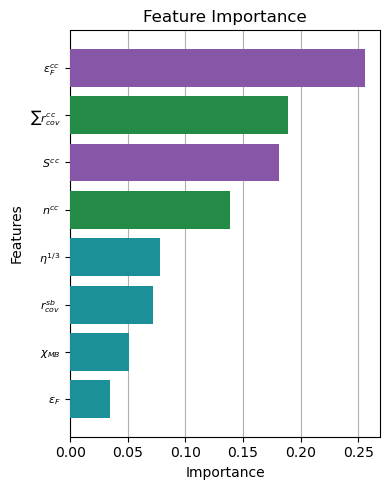

In [2]:
# Feature importance values
feature_importance = {
    'E_Fermi': 0.0349889830085655,
    'MB_electroneg': 0.051468824441862265,
    'fermi_energy_cavity': 0.256025697786134,
    'mied_param_h': 0.07758893191456132,
    'ncoord': 0.13833656703656258,
    'r_cov_sb': 0.07156780775165847,
    'sum(r)': 0.18910584320015786,
    'surface': 0.18091734486049796
}

# LaTeX-style label mapping
feature_name_mapping = {
    'E_Fermi': r'$\varepsilon_F$',  
    'MB_electroneg': r'$\chi_{MB}$', 
    'fermi_energy_cavity': r'$\varepsilon^{cc}_{F}$',  
    'mied_param_h': r'$\eta^{1/3}$', 
    'ncoord': r'$n^{cc}$',  
    'r_cov_sb': r'$r^{sb}_{cov}$',  
    'sum(r)': r'$\sum r^{cc}_{cov}$',  
    'surface': r'$S^{cc}$'  
}

# Custom color map
colors = {
    'E_Fermi': 'rgb(28,144,153)',
    'MB_electroneg': 'rgb(28,144,153)',
    'fermi_energy_cavity': 'rgb(136,86,167)',
    'mied_param_h': 'rgb(28,144,153)',
    'ncoord': 'rgb(35,139,69)',
    'r_cov_sb': 'rgb(28,144,153)',
    'sum(r)': 'rgb(35,139,69)',  
    'surface': 'rgb(136,86,167)'
}

plot_feature_importance(
    feature_importance=feature_importance,
    feature_name_mapping=feature_name_mapping,
    color_map=colors,
    #save_dir="../../../data/figures/rfr_results",
    #filename="mdi_features",
    save_formats=["png", "svg", "pdf"],
    dpi=300
)



## Pearson Correlation Matrix

This heatmap visualizes the Pearson correlation coefficients between selected features in the dataset. The Pearson correlation measures the linear relationship between pairs of variables, with values ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation). Values close to 0 indicate little to no linear correlation.

The heatmap uses LaTeX-style symbols to clearly label the features, enhancing readability and presentation quality. The upper triangle of the matrix is masked to avoid redundancy since the correlation matrix is symmetric.

Understanding these correlations helps identify which features are strongly related, which can inform feature selection and engineering in downstream machine learning tasks.

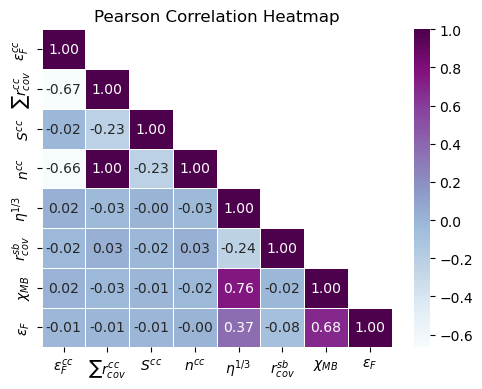

In [3]:
data_rfr_dacs_path = "../../../data/out/df_rfr_dacs_results.csv"
df_corr = pd.read_csv(data_rfr_dacs_path)

feature_name_mapping = {
    'fermi_energy_cavity': r'$\varepsilon^{cc}_{F}$',
    'sum(r)': r'$\sum r^{cc}_{cov}$',
    'surface': r'$S^{cc}$',
    'ncoord': r'$n^{cc}$',
    'mied_param_h': r'$\eta^{1/3}$',
    'r_cov_sb': r'$r^{sb}_{cov}$',
    'MB_electroneg': r'$\chi_{MB}$',
    ' E_Fermi': r'$\varepsilon_F$',  # Fixed leading space in your original dict key
}

plot_pearson_correlation(
    df=df_corr,
    feature_name_mapping=feature_name_mapping,
    #save_dir="../../../data/figures/rfr_results",
    #filename="pearson_corr"
)


##  Mean Absolute Error by Metal Category

This section visualizes the predictive performance of the model across different metal categories by computing the mean absolute error (MAE) per metal. The error is aggregated across cross-validation folds and displayed with standard deviation as error bars. This diagnostic helps identify if the model performs better for certain metals and worse for others, indicating potential data imbalance or model bias.

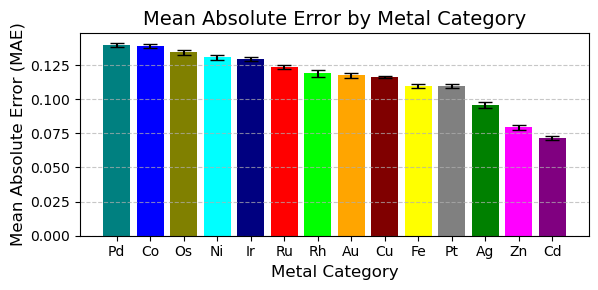

In [4]:
metal_colors = {
    "Ru": "rgb(255, 0, 0)",
    "Rh": "rgb(0, 255, 0)",
    "Co": "rgb(0, 0, 255)",
    "Fe": "rgb(255, 255, 0)",
    "Zn": "rgb(255, 0, 255)",
    "Ni": "rgb(0, 255, 255)",
    "Os": "rgb(128, 128, 0)",
    "Cd": "rgb(128, 0, 128)",
    "Pd": "rgb(0, 128, 128)",
    "Cu": "rgb(128, 0, 0)",
    "Ag": "rgb(0, 128, 0)",
    "Ir": "rgb(0, 0, 128)",
    "Au": "rgb(255, 165, 0)",
    "Pt": "rgb(128, 128, 128)",
}

df = pd.read_csv("../../../data/out/df_rfr_dacs_results.csv")

plot_mae_by_metal(
    df=df,
    true_value_col="Eads",
    pred_prefix="pred_",
    metal_col="M1",
    metal_colors=metal_colors,
    n_folds=10,
    figsize=(6,3),
    # save_dir="../../../data/figures/rfr_results",
    # filename="metal_mae",
    # save_formats=["png", "svg", "pdf"],
    # dpi=300,
)


## Mean Absolute Error by Number of Carbon Atoms


This plot visualizes the Mean Absolute Error (MAE) for different categories based on the number of carbon atoms (`cavity_3`). 
It averages MAE values across 10-fold cross-validation results for multiple prediction models and includes error bars to indicate variability. 
This helps assess how prediction accuracy varies with molecular size or structure.


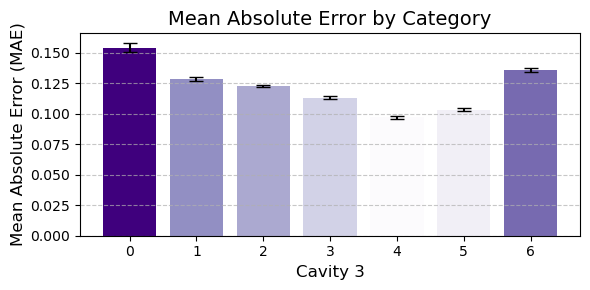

In [5]:
data_rfr_dacs = "../../../data/out/df_rfr_dacs_results.csv"
df = pd.read_csv(data_rfr_dacs)

# Call the function to generate the plot
plot_mae_by_category(
    df=df,
    group_col="cavity_3",
    # save_path="../../../data/figures/rfr_results",
    # title="Mean Absolute Error by Cavity Category (with Error Bars)"
)


## Averaging Predictions Across Cross-Validation Folds


This step computes the average of all predicted values from different cross-validation folds for each sample, resulting in a consensus prediction (`y_pred`). The updated DataFrame is then saved for further analysis or evaluation.

In [6]:

# Load the data
data_rfr_dacs = "../../../data/out/df_rfr_dacs_results.csv"
df = pd.read_csv(data_rfr_dacs)

# List of prediction columns (assuming they all start with 'pred_')
prediction_columns = [col for col in df.columns if col.startswith('pred_')]

# Calculate the mean predicted value across the columns and add it as a new column
df['y_pred'] = df[prediction_columns].mean(axis=1)

# Save the updated DataFrame if needed
output_path = "../../../data/out/df_rfr_dacs_results_with_y_pred.csv"
df.to_csv(output_path, index=False)


## Most Stable DACs Predicted by RFR (10-fold CV)

This cell identifies the 10 DAC systems with the lowest predicted adsorption energies (`y_pred`) from the RFR model. These entries are likely the most stable configurations according to the model, as lower adsorption energies typically indicate stronger binding. The values are sorted in ascending order and shown with two decimal places.

In [7]:
# Sort the DataFrame by the 'y_pred' column in ascending order
sorted_df = df.sort_values(by='y_pred', ascending=True)

# Extract the 10 rows with the lowest y_pred values and the corresponding system_dacs values
lowest_y_pred = sorted_df[['y_pred', 'system_dacs']].head(10)

lowest_y_pred = lowest_y_pred.copy()
lowest_y_pred['y_pred'] = lowest_y_pred['y_pred'].round(2)

# Print the result
print("The 10 most stable DACs on N-doped carbon:")
print(lowest_y_pred)


'The 10 most stable DACs on N-doped carbon:'
     y_pred           system_dacs
164   -7.15  Co_Fe_N_din4_x2_c1_b
73    -7.14  Ni_Fe_N_din4_x2_c2_f
199   -7.14    Fe_Fe_N_din4_x2_c0
208   -7.14  Fe_Fe_N_din4_x2_c2_f
110   -7.10  Fe_Fe_N_din4_x2_c1_b
17    -7.07    Co_Fe_N_din4_x2_c0
170   -6.98  Ni_Fe_N_din4_x2_c1_b
21    -6.87    Ni_Fe_N_din4_x2_c0
203   -6.32  Ni_Fe_N_din4_x2_c3_a
236   -6.27  Co_Fe_N_din4_x2_c3_a


### Most stable DACs for N_din4_x2_c0

In [8]:

# Filter the DataFrame for rows where 'cavity_v2' contains 'N_din4_x2_c0'
filtered_df = df[df['cavity_v2'] == 'N_din4_x2_c0']

# Sort the filtered DataFrame by 'y_pred' in ascending order
sorted_filtered_df = filtered_df.sort_values(by='y_pred', ascending=True)

# Extract the 10 rows with the lowest y_pred values and the corresponding 'system_dacs' values
lowest_y_pred_filtered = sorted_filtered_df[['y_pred', 'system_dacs']].head(14)

# Print the result
print("The 10 most stable M1_M2_N_din4_x2_c0:")
print(lowest_y_pred_filtered)




'The 10 most stable M1_M2_N_din4_x2_c0:'
       y_pred         system_dacs
199 -7.142048  Fe_Fe_N_din4_x2_c0
17  -7.072240  Co_Fe_N_din4_x2_c0
21  -6.871692  Ni_Fe_N_din4_x2_c0
160 -6.116477  Rh_Fe_N_din4_x2_c0
37  -6.076010  Ir_Fe_N_din4_x2_c0
99  -5.930059  Pt_Fe_N_din4_x2_c0
222 -5.746291  Pd_Fe_N_din4_x2_c0
248 -5.736903  Os_Fe_N_din4_x2_c0
19  -5.293585  Zn_Fe_N_din4_x2_c0
46  -5.196607  Cu_Fe_N_din4_x2_c0
195 -4.156691  Au_Fe_N_din4_x2_c0
252 -4.093957  Cd_Fe_N_din4_x2_c0
94  -3.725847  Ag_Fe_N_din4_x2_c0


### Most stable DACs din4_x2

In [9]:
# Filter the DataFrame where 'cavity_v2' contains 'din4_x2'
filtered_df = df[df['cavity_v2'].str.contains('din4_x2', na=False)]

# Sort the filtered DataFrame by 'y_pred' in ascending order
sorted_filtered_df = filtered_df.sort_values(by='y_pred', ascending=True)

# Extract the 10 rows with the lowest y_pred values and the corresponding 'system_dacs' values
lowest_y_pred_filtered = sorted_filtered_df[['y_pred', 'system_dacs']].head(8)
print(lowest_y_pred_filtered)


# Extract the 8 rows with the lowest y_pred values
din4_x2_stable_rfr = sorted_filtered_df.head(8)

# Save these rows to the specified CSV file
path_stable_din4_x2 = "../../../data/out/din4_x2_stable_rfr.csv"
din4_x2_stable_rfr.to_csv(path_stable_din4_x2, index=False)



       y_pred           system_dacs
164 -7.147929  Co_Fe_N_din4_x2_c1_b
73  -7.142399  Ni_Fe_N_din4_x2_c2_f
199 -7.142048    Fe_Fe_N_din4_x2_c0
208 -7.141469  Fe_Fe_N_din4_x2_c2_f
110 -7.099170  Fe_Fe_N_din4_x2_c1_b
17  -7.072240    Co_Fe_N_din4_x2_c0
170 -6.979263  Ni_Fe_N_din4_x2_c1_b
21  -6.871692    Ni_Fe_N_din4_x2_c0


### Most stable DACs din6_as

In [10]:


# Filter the DataFrame where 'cavity_v2' contains 'din6_s'
filtered_df = df[df['cavity_v2'].str.contains('din6_as', na=False)]

# Sort the filtered DataFrame by 'y_pred' in ascending order
sorted_filtered_df = filtered_df.sort_values(by='y_pred', ascending=True)


# Extract the 10 rows with the lowest y_pred values and the corresponding 'system_dacs' values
lowest_y_pred_filtered = sorted_filtered_df[['y_pred', 'system_dacs']].head(10)
print(lowest_y_pred_filtered)

# Extract the 10 rows with the lowest y_pred values
din6_as_stable_rfr = sorted_filtered_df.head(10)

# Save these rows to the specified CSV file
# path_stable_din6_as = "../../../dacs_ml_github/data/out/din6_as_stable_rfr.csv"
# din6_as_stable_rfr.to_csv(path_stable_din6_as, index=False)
#print(din6_as_stable_rfr)



       y_pred               system_dacs
451 -4.279509    Ni_Fe_N_din6_as_c3_253
694 -4.279509    Ni_Fe_N_din6_as_c3_235
461 -4.168420    Ni_Fe_N_din6_as_c3_254
523 -4.126048    Ni_Fe_N_din6_as_c3_125
663 -4.071238    Zn_Fe_N_din6_as_c3_254
743 -4.035241    Zn_Fe_N_din6_as_c3_125
335 -4.023547    Pt_Fe_N_din6_as_c3_235
329 -4.023547    Pt_Fe_N_din6_as_c3_253
345 -3.979173    Ni_Fe_N_din6_as_c3_236
372 -3.950475  Ni_Fe_N_din6_as_c5_12345


### Most stable DACs din6_s

In [11]:
# Filter the DataFrame where 'cavity_v2' contains 'din6_s'
filtered_df = df[df['cavity_v2'].str.contains('din6_s', na=False)]

# Sort the filtered DataFrame by 'y_pred' in ascending order
sorted_filtered_df = filtered_df.sort_values(by='y_pred', ascending=True)

# Extract the 10 rows with the lowest y_pred values and the corresponding 'system_dacs' values
lowest_y_pred_filtered = sorted_filtered_df[['y_pred', 'system_dacs']].head(8)
print(lowest_y_pred_filtered)

# Extract the 8 rows with the lowest y_pred values
din6_s_stable_rfr = sorted_filtered_df.head(8)

# Save these rows to the specified CSV file
path_stable_din6_s = "../../../data/out/din6_s_stable_rfr.csv"
din6_s_stable_rfr.to_csv(path_stable_din6_s, index=False)
#print(din6_as_stable_rfr)

       y_pred        system_dacs
648 -3.975198  Pt_Fe_C_din6_s_c6
656 -3.839888  Pd_Fe_C_din6_s_c6
436 -3.692658  Ni_Fe_C_din6_s_c6
316 -3.677309  Zn_Fe_C_din6_s_c6
497 -3.662924  Fe_Fe_C_din6_s_c6
720 -3.597163  Rh_Fe_C_din6_s_c6
654 -3.545998  Co_Fe_C_din6_s_c6
718 -3.465192  Ir_Fe_C_din6_s_c6


## Stability-Synergistic Effect Trade-offs

This plot visualizes the trade-off between predicted adsorption energies ($E^{RFR}{\mathrm{ads}}$) and interaction energies ($E{\mathrm{int}}$) for a series of catalyst systems. The lower-left quadrant (both values negative) represents thermodynamically stable and catalytically active configurations. Highlighted points indicate specially selected systems, and blue markers denote the configurations with the lowest predicted adsorption and interaction energies within the stable region.

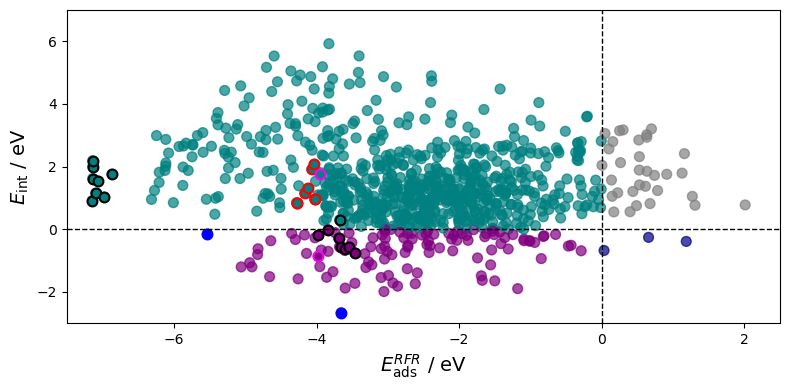

In [12]:
#save_path = '../../../data/figures/rfr_results/stability_adsorption'
plot_stability_adsorption(df, show_plot=True)

## Correlation plot of the a selected feature and the adsorption energy

This plot shows the relationship between a selected regression feature (e.g., Fermi energy) and the predicted adsorption energy ($E^{RFR}_{\mathrm{ads}}$) for three different dinuclear catalyst datasets. Data points are color-coded by a secondary feature (e.g., cavity descriptor) and annotated with the metal identity of the active site to facilitate comparison across structural motifs.

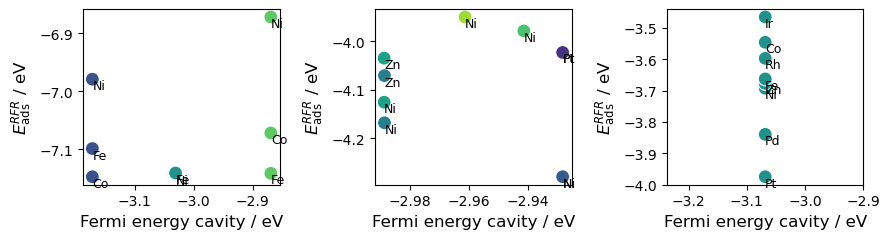

In [13]:
plot_feature_vs_prediction(
    din4_x2=din4_x2_stable_rfr,
    din6_as=din6_as_stable_rfr,
    din6_s=din6_s_stable_rfr,
    regression_feature='fermi_energy_cavity',  # ← your custom feature
    hue_feature='cavity_v2',
    #save_path='../../../data/figures/rfr_results/Ef_ypred_region'
)
